<img align="center" src="https://www.quotemaster.org/images/6c/6cd4402a3a471df34ea4e9232fe6d3cd.jpg" width="350"> 


# Семинар 6: Регрессия - моя профессия!

Ура! Ура! Ура! Наконец-то пришло время поговорить о регрессии. Да не простой регрессии, а линейной! Это первый алгоритм машинного обучения, который мы обсудим. 

__Задача:__  как вы уже поняли по ручным задачам, мы будем прогнозировать сколько лайков поставит первокурсник под пабликом с мемами по его характеристикам. Число лайков - непрерывная переменная. Значит мы решаем задачу регрессии. 

In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

## 1. Метрики в задаче регрессии

Мы решаем задачу регрессии. Нужно прогнозировать действительные числа. Качество прогнозов, которые мы делаем нужно оценивать с помощью какой-то метрики. В ручной части семинара мы обсудили с вами несколько метрик. Мы при решении задачи будем использовать MAE и RMSE.

In [2]:
from sklearn import metrics  # подгружаем метрики

y_test = [4,20,110]
y_pred = [5,10,100]

metrics.mean_absolute_error(y_test, y_pred)

7.0

In [3]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

8.18535277187245

Давайте напишим небольшую функцию, с помощью которой нам будем немного удобнее выводить эти две метрики на экран.

In [4]:
from sklearn import metrics  # подгружаем метрики

# функция, которая считает метрики и выводит их на экран
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    pass

print_metrics(y_test,y_pred)

MAE: 7.0
RMSE: 8.18535277187245


С тем какую задачу мы решаем и какие метрики используем определились. Давайте теперь посмотрим на данные.

## 2. Данные. Какие данные? 

Подгружаем табличку с лайками и смотрим на неё.

In [5]:
df = pd.read_csv('../data/vk_main.csv', sep='\t')   # подгружаем датасет
print('Размерность таблицы:', df.shape)             # shape показывает его размер
df.head()                                           # head выдаёт первые 5 строк

Размерность таблицы: (335, 96)


,city,country,first_name,home_town,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Москва,Россия,Артём,MOSCOW,Еркин,0,181029517,1,0,0,...,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,16.0,0.375000
1,NaN,Россия,Армен,NaN,Хачатрян,15,73703994,1,0,1,...,1.750000,4.0,1.0,0.571429,1.0,0.0,0.0,0.0,47.0,0.531915
2,Москва,Россия,Abbos,Бекабад,Akhmedov,11,467673028,1,0,0,...,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,26.0,0.500000
3,Москва,Россия,Адам,NaN,Триандафилиди,0,144910934,1,0,1,...,1.428571,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,83.0,0.518072
4,Алматы,Казахстан,Айжан,NaN,Саят,9,166045266,0,0,0,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,29.0,0.344828


__Сколько у нас всего наблюдений? Сколько в таблице переменных?__

### 2.1 Что прогнозируем?

Построим несколько картинок, чтобы немного лучше прочувствовать выборку. Посмотрим на то, какое распределение у целевой переменной (число лайков в паблике). 

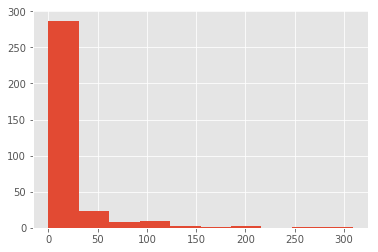

In [6]:
df.likes_memes.hist();

У распределения лайков есть проблема - очень длинный хвост. В выборке встречаются люди, которые слишком сильно любят мемы. Такие наблюдения называются __выбросами.__ С ними нужно бороться, иначе модель подстроится под них. Давайте сгладим распределение лайков, прологарифмировав его. На практике так делают довольно часто. Это позволяет немного уменьшить перепады и сгладить хвост.

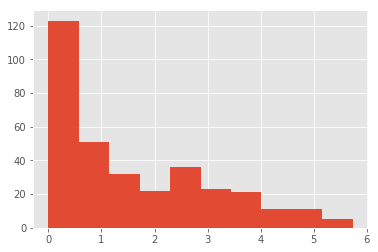

In [7]:
df['ln_likes_memes'] = df['likes_memes'].apply(lambda w: np.log(w + 1))
df.ln_likes_memes.hist();

Выглядит немного лучше. Мы попробуем построить регрессию для обоих таргетов и посмотреть что получится. __Обратите внимание, что в распределении есть два пика. Как бы вы это объяснили?__ 

### 2.2 Объясняющие переменные

Посмотрим на пропуски. На картинке ниже жёлтая клетка - это пропуск. Лиловая - это наблюдение. 

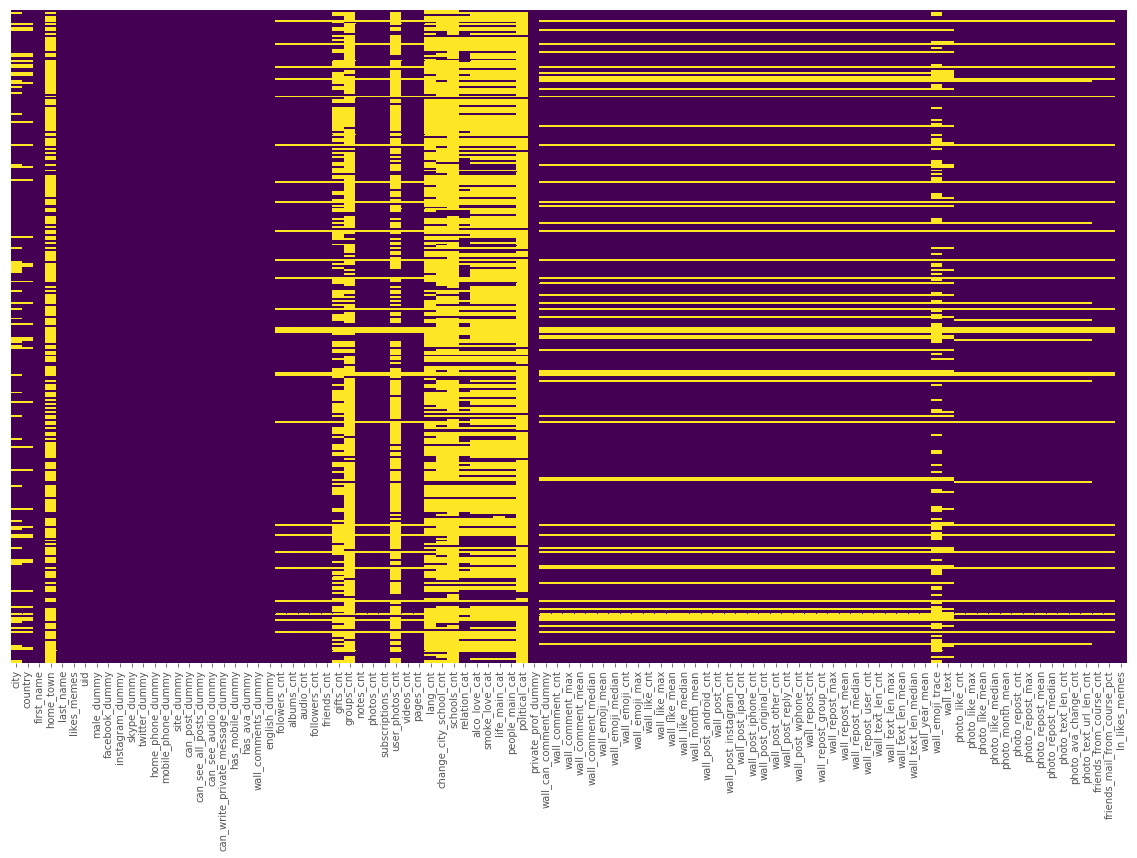

In [8]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Есть столбики с очень большим числом пропусков. Давайте выкинем из рассмотрения все данные, где пропусков больше $60$. Большая часть пропусков сопряжена с приватными страничками. Всего такиех страничек $56$. Давайте договоримся выбросить все переменные, где больше $56$ пропусков.

In [9]:
print('Переменных до выбрасывания:', df.shape)

isnull = df.isnull().sum()
df = df[isnull[isnull <= 56].index]

print('Переменных после выбрасывания:', df.shape)

Переменных до выбрасывания: (335, 97)
Переменных после выбрасывания: (335, 81)


Все переменные, которые есть в выборке делятся на несколько типов. Я специально постарался отразить их типы в названиях. Давайте посмотрим на то, какие это типы.

### Переменные счётчики

Количество друзей, количество подписчиков, число фоток - всё это счётчики!

In [10]:
variables_cnt = [item for item in df.columns if item[-3:] == 'cnt']
variables_cnt[:5]

['folowers_cnt', 'albums_cnt', 'audio_cnt', 'followers_cnt', 'friends_cnt']

Давайте посмотрим на распределения таких переменных. У них будет проблема. Очень многие из них будут подвержены наличию выбросов. Более того, многие будут неинформативными. Например, переменная `photo_ava_change_cnt` абсолютно бесполезная, так как принимает только одно значение для всех ниблюдений. Смысл этой переменной - сколько раз человек поменял аватар. Видимо, она неправильно была записана в таблицу при сборе данных. В реальности такие косяки встречаются довольно часто. Надо быть к ним готовым.

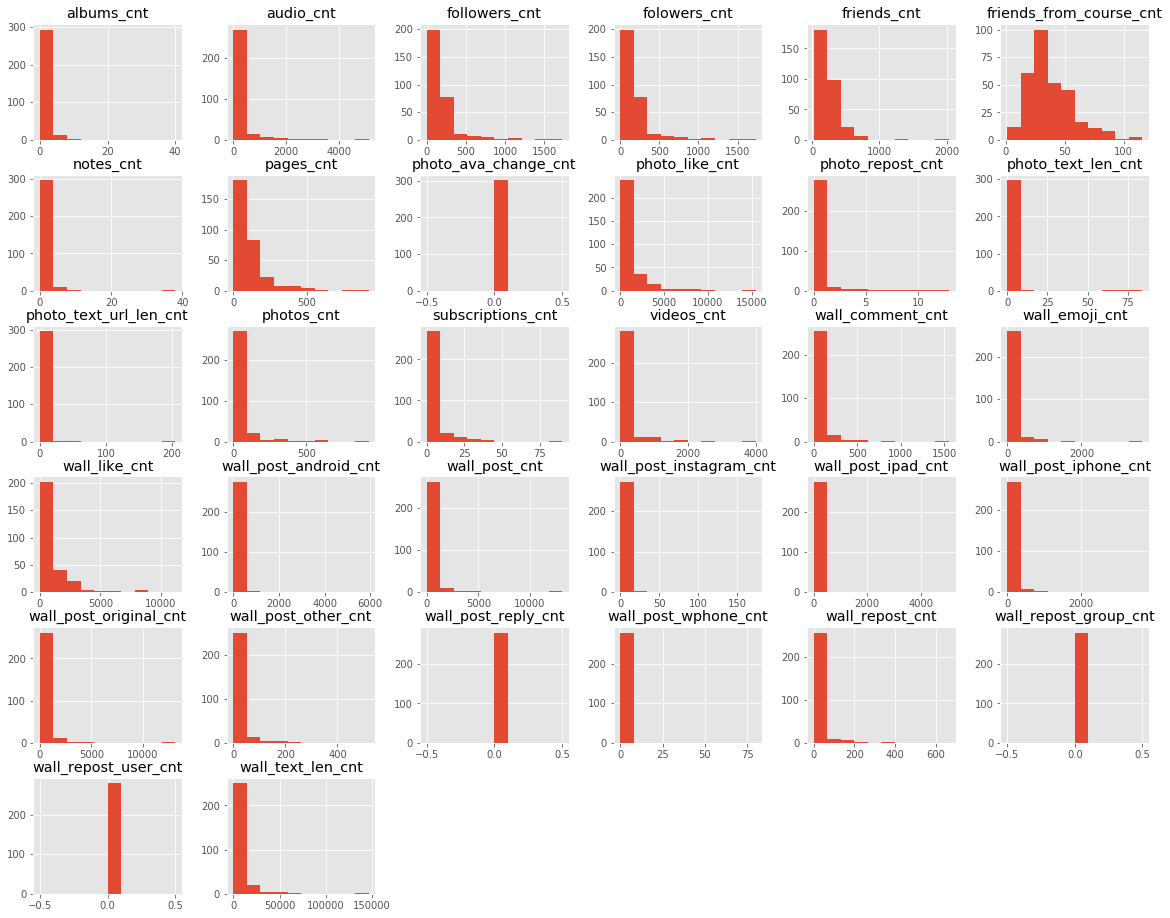

In [11]:
df[variables_cnt].hist(figsize=(20,16));

Выбрасываем все неинформативные переменные-счётчики. 

In [12]:
df['wall_repost_user_cnt'].unique()

array([ 0., nan])

In [13]:
print('Переменных-счётчиков до отбрасывания:', len(variables_cnt))

# Оставим только те счётчики, которые принимают больше 10 значений 
variables_cnt = [item for item in variables_cnt if len(df[item].unique()) > 10]

print('Переменных-счётчиков после отбрасывания:', len(variables_cnt))

Переменных-счётчиков до отбрасывания: 32
Переменных-счётчиков после отбрасывания: 25


Всё, что осталось, прологарифмируем. Мы делаем эточ, чтобы немного сгладить длинные хвосты с выбросами.

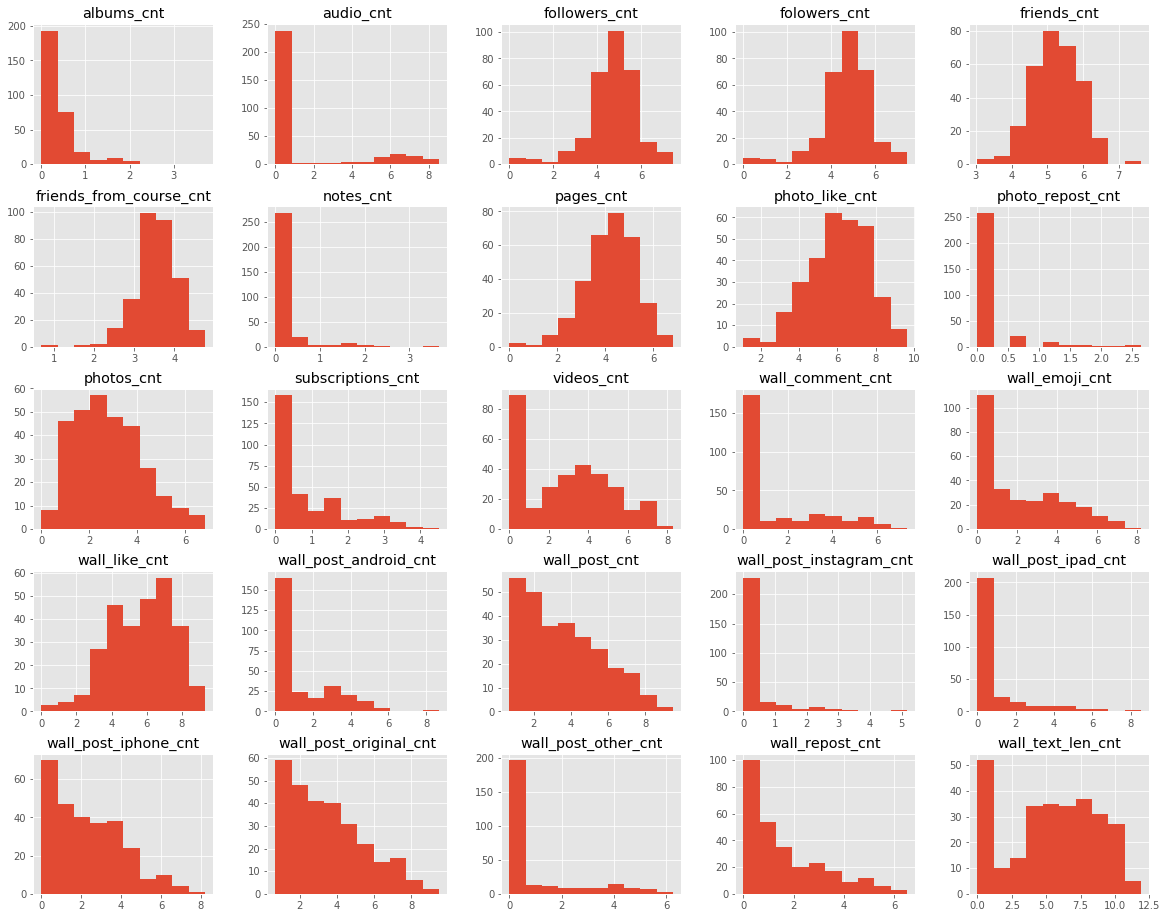

In [14]:
df[variables_cnt] = df[variables_cnt].apply(lambda w: np.log(w + 1))
df[variables_cnt].hist(figsize=(20,16));

### Дамми-переменные

Это переменные, которые принимают два значения: либо ноль, либо один.

In [15]:
variables_dummy = [item for item in df.columns if item[-5:] == 'dummy']
variables_dummy[:5]

['male_dummy',
 'facebook_dummy',
 'instagram_dummy',
 'skype_dummy',
 'twitter_dummy']

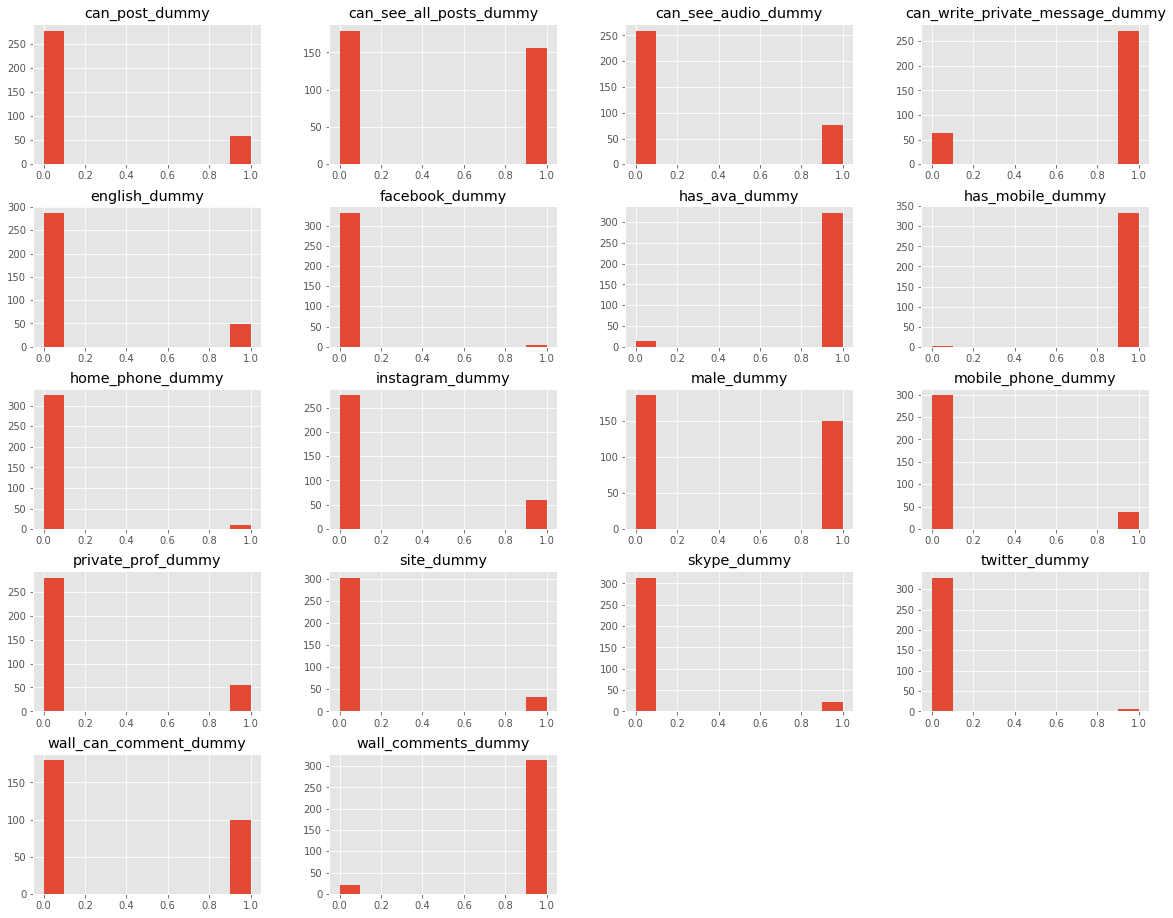

In [16]:
df[variables_dummy].hist(figsize=(20,16));

Есть несколько не очень информативных переменных. Например, наличие твиттера или указан ли телефон. Почти у всех там стоят нули. То есть твиттер и телефон не указаны. Можно было бы выкинуть эти переменные, но мы пожалуй не будем. 

### Категориальные переменные 

Название говорит само за себя. 

In [17]:
variables_cat = [item for item in df.columns if item[-3:] == 'cat']
variables_cat[:5]

[]

В данных их нет. Угадаете почему? Изначально то они там были... Куда мы их дели?

### Средние, медианы, максимумы и другие описательные статистики

Мы посчитали по каждому пользователю среднее число комментов на стене, среднее количество репостов, эмодзи и другие подобные характеристики. Также сделали с медианами и максимумами.

In [18]:
variables_mean = [item for item in df.columns if item[-4:] == 'mean']
variables_mean[:5]

['wall_comment_mean',
 'wall_emoji_mean',
 'wall_like_mean',
 'wall_month_mean',
 'wall_repost_mean']

In [19]:
variables_median = [item for item in df.columns if item[-6:] == 'median']
variables_median[:5]

['wall_comment_median',
 'wall_emoji_median',
 'wall_like_median',
 'wall_repost_median',
 'wall_text_len_median']

In [20]:
variables_max = [item for item in df.columns if item[-3:] == 'max']
variables_max[:5]

['wall_comment_max',
 'wall_emoji_max',
 'wall_like_max',
 'wall_repost_max',
 'wall_text_len_max']

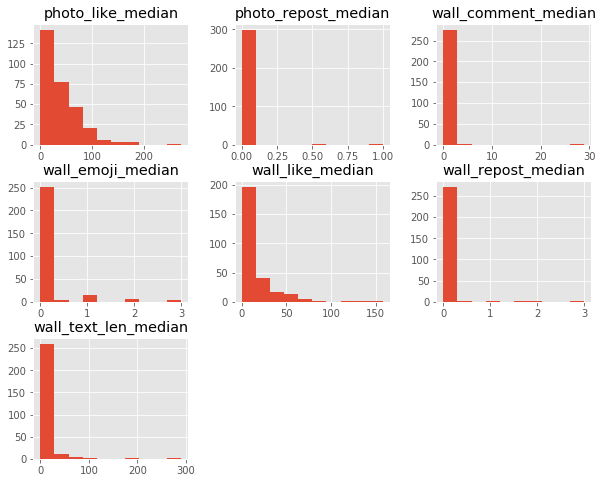

In [21]:
df[variables_median].hist(figsize=(10,8));

Давайте эти переменные тоже прологарифмируем.

In [22]:
variables_descriptive = variables_median + variables_mean + variables_max
df[variables_descriptive] =  df[variables_descriptive].apply(lambda w: np.log(w + 1))

Обратите внимание на следущую вещь: медианы и средние сильно дублируют друг-друга. Каждая по-своему пытается уловить одну и ту же информацию. Правда медиана это делает поустойчивее к выбросам, нежели среднее. Возможно, в итоговую модель имеет смысл брать только какие-нибудь одни из них (но это неточно).

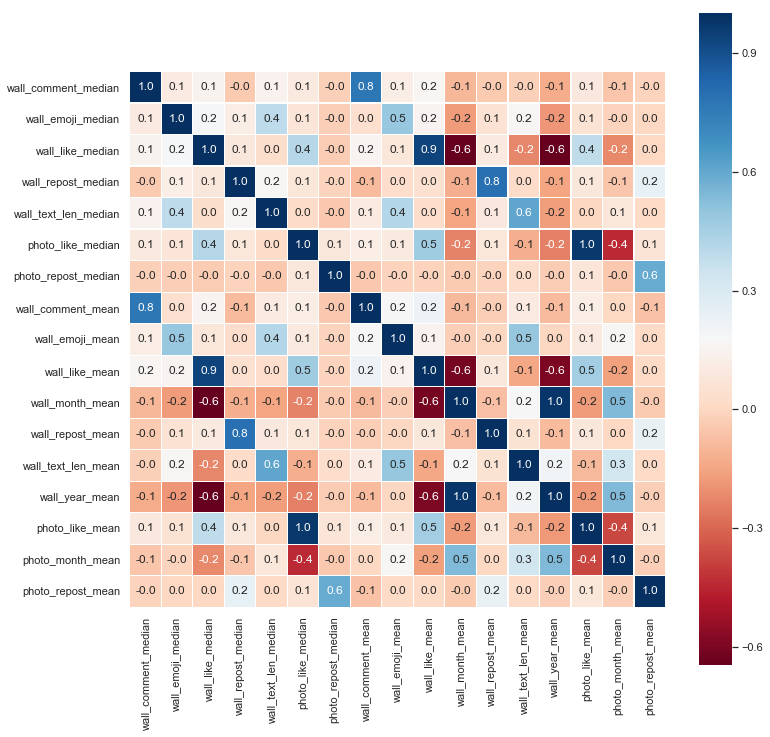

In [23]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df[variables_median + variables_mean].corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

### Другие переменные 

В данных осталось ещё немного переменных. Давайте посмотрим что это. 

In [24]:
variables = df.columns

# мы выкинули неинформативные счётчики, придётся найти их заново
variables_cnt_reserve = [item for item in variables if item[-3:] == 'cnt']

variables_another = list(set(variables) - set(variables_cnt_reserve) - set(variables_dummy) - 
          set(variables_cat) - set(variables_descriptive))

df[variables_another].head()

,ln_likes_memes,likes_memes,uid,country,first_name,friends_mail_from_course_pct,last_name
0,0.000000,0,181029517,Россия,Артём,0.375000,Еркин
1,2.772589,15,73703994,Россия,Армен,0.531915,Хачатрян
2,2.484907,11,467673028,Россия,Abbos,0.500000,Akhmedov
3,0.000000,0,144910934,Россия,Адам,0.518072,Триандафилиди
4,2.302585,9,166045266,Казахстан,Айжан,0.344828,Саят


Тут, в основном, технические переменные, наш таргет, а также доля девушек среди всех друзей с курса. Девушек с курса возьмём в итоговые переменные, остальное выбросим.

Ещё разок давайте глянем на пропуски. 

In [25]:
# Список полезных переменных =)
useful_variables = variables_cnt + variables_dummy + variables_descriptive + ['friends_mail_from_course_pct']

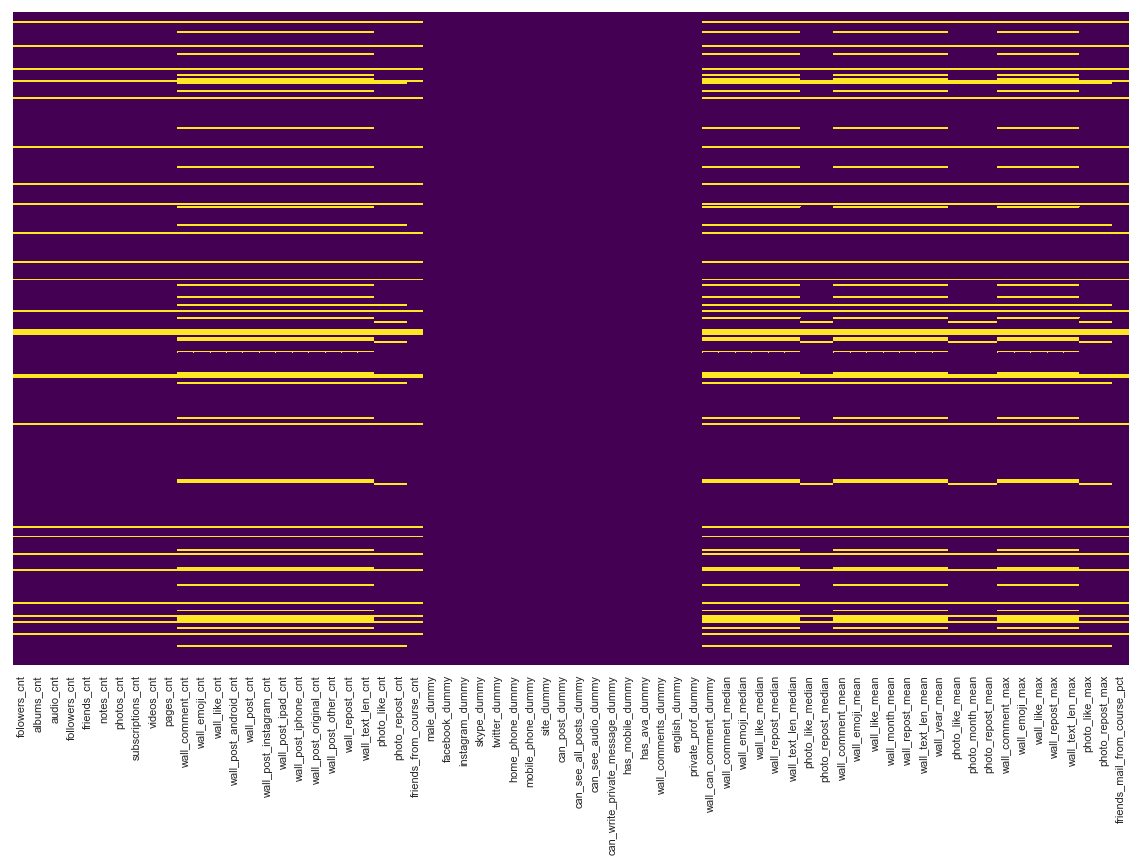

In [26]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df[useful_variables].isnull(), yticklabels=False, cbar=False, cmap='viridis')

Заполним их все нулями.

In [27]:
df[useful_variables] = df[useful_variables].fillna(0)

Данные, с которыми мы работаем, были довольно чистыми и предобработку пришлось делать не в особо больших количествах. Обычно предобработка идёт куда дольше и хардкорнее. Об этом мы обязательно поговорим отдельно. 

Всё! Переходим к моделированию. 

## 3. Пробуем построить модель

Разделим выборку на две части: тренировочную и тестовую. Давайте вспомним зачем это делают. Когда мы обучаем модель на тренировочных данных, нам хочется понять насколько хорошо она работает в боевых условиях. Выборка, на которой мы учимся, не подходит для этих целей. Так как знания об этих объектах уже будут лежать в нашей модели, а в реальной жизни будут встречаться и новые, ранее неизвестные объекты. 

Давайте отложим часть объектов в тестовую выборку. Будем учить алгоритм только на тренировочной. Тогда при обучении алгоритм не увидит тестовые примеры. Значит можно использовать её для имитации этих самых новых объектов из реальной жизни и посмотреть какое на них будет качество. 

Раздробим всё, что имеем на две части. Одна часть будет чуть больше, другая чуть меньше. Обычно на обучение пускают 70-80%, а на тест 30-20% выборки. 

In [28]:
from sklearn.model_selection import train_test_split  # функция для деления 

# делим в пропорции 80 к 20
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42) 

Для удобства вытащим из таблицы матрицы.

In [29]:
# для удобства запишем в y то, что мы хотим спрогнозировать, а в X то, по чему мы это будем делать.
y_train = df_train['ln_likes_memes'].get_values()
y_test = df_test['ln_likes_memes'].get_values()

X_train = df_train[useful_variables].get_values()
X_test = df_test[useful_variables].get_values()

## 3.1 Наивный прогноз 

Шаг первый. Построим константный прогноз. Будем говорить, что каждый человек ставит под постом среднее количество лайков.

In [30]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им лайки
y_pred_naive[:5]

array([1.54493374, 1.54493374, 1.54493374, 1.54493374, 1.54493374])

In [31]:
# та самая функция, которую мы сделали в самом начале тетрадки
print_metrics(y_test, y_pred_naive)

MAE: 1.3087434843958783
RMSE: 1.5122274344074955


__Что означают эти числа? Почему так мало лайков ставят студенты?!__

In [1]:
import numpy as np
np.exp(1.3)

3.6692966676192444

## 3.2  Линейная регрессия

Пришло время построить линейную регрессию! Эта модель говорит, что число лайков формируется в результате суммирования тех характеристик, которыми обладает студент с какими-то весами

$$\hat{y} = \beta_0 + \beta_1 x_1 + ... \beta_n x_n.$$

Например, если мы оценили модель и у нас получилось, что 

$$ likes = 5 + 2 \cdot male\_dummy $$

то это означает, что среднее число лайков от студента равно $5$, но при этом если студент парень, он в принципе ставит на два лайка больше. То есть модель говорит, что парни на лайки щедрее дам. 

Для того, чтобы подобрать коэффициенты обычно минимизируют MSE. Пусть компьютер сделает это за нас. Заставим вкалывать этот кусок железа во имя мемов!

In [32]:
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

Посмотрим на ошибку прогноза на тестовой выборке. По сравнению с наивным прогнозом она упала. Это хорошо. Значит наша регрессия уловила какую-то полезную информацию. Ошибка пока что падает не особо сильно. Давайте попробуем улучшить нашу модель.

In [33]:
print_metrics(y_test, y_pred_regr)

MAE: 1.1494773395901723
RMSE: 1.471778023850668


## 3.3 Чистка переменных 

In [34]:
df_train.shape

(268, 81)

In [35]:
268/81

3.308641975308642

У нас в данных $268$ наблюдений и $81$ переменная. На то, чтобы оценить один коэффициент мы тратим $\frac{268}{81} \approx 3$ наблюдения. Это очень мало. Чем больше пропроция $\frac{число\mbox{ }наблюдений}{число\mbox{ }переменных}$, тем лучше. Давайте попробуем отобрать только самые классные переменные. Для этого посчитаем корреляцию каждой переменной с таргетом. Возьмём только те, где корреляция большая.

In [36]:
corr_neg = df_train[useful_variables].corrwith(df_train['ln_likes_memes']).sort_values()
corr_neg[:10]

male_dummy                        -0.189100
mobile_phone_dummy                -0.139124
private_prof_dummy                -0.114836
home_phone_dummy                  -0.100536
twitter_dummy                     -0.094392
subscriptions_cnt                 -0.065627
can_see_audio_dummy               -0.041980
can_write_private_message_dummy   -0.038983
wall_post_other_cnt               -0.032235
photo_repost_cnt                  -0.032062
dtype: float64

In [37]:
corr_pos = df_train[useful_variables].corrwith(df_train['ln_likes_memes']).sort_values(ascending=False)
corr_pos[:10]

friends_from_course_cnt    0.189541
videos_cnt                 0.169906
photo_like_cnt             0.152362
pages_cnt                  0.148617
wall_text_len_mean         0.131349
photo_like_max             0.130574
photos_cnt                 0.125206
friends_cnt                0.119027
photo_like_mean            0.118823
photo_like_median          0.113274
dtype: float64

Ну, например, возьмём $10$ самых негативных и $10$ самых позитивных.  

In [38]:
best_variables = list(corr_pos[:10].index) + list(corr_neg[:10].index)

In [39]:
# Забираем в выборку лучших из лучших 

X_train = df_train[best_variables].get_values()
X_test = df_test[best_variables].get_values()

In [40]:
X_train.shape

(268, 20)

Теперь у нас на оценку одного коэффициента приходится $\frac{268}{20} = 13.4$ наблюдений. Это получше, но теперь есть опасность, что мы не очень правильно отобрали переменные в нашу итоговую модель. Отбор переменных это отдельная очень большая тема. Там есть куча разных приёмов. О ней тоже поговорим как-нибудь в другой раз. Пока что остановимся только на приёме, состоящем в подсчёте корреляции с целевой переменной. 

In [41]:
268/20

13.4

In [42]:
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

print_metrics(y_test, y_pred_regr)

MAE: 1.1999814773308883
RMSE: 1.503414386191363


Что мы видим? Видим, что ошибка при выкидывании кучи переменных почти не изменилась. Судя по всему, все эти переменные не несли о числе лайков никакой информации. Будем дальше работать только с отобранной нами двадцаткой.

## 3.4 Меняем функцию для оптимизации 

При стрьительстве моделей выше мы пользовались классом `LinearRegression()`, он пытается минимизировать $MSE$.  Мы с вами увидели в начале тетрадки, что в данных много переменных с длинными хвостами. То есть в данных есть выбросы, с которыми могут возникать проблемы. Конечно же, мы попытались сгладить их, но не факт, что это хорошо получилось. Давайте попробуем дать им бой и использовать для обучения модели другую функцию потерь, устойчивую к выбросам. Это будет некая модернизация $MAE$.  Вы же ещё не забыли, что $MAE$ устойчива к выбросам из-за своего модуля?  Для этого позовём новый класс, `HuberRegressor( )`, который строит регрессию устойчивую к выбросам. 

In [43]:
from sklearn.linear_model import HuberRegressor

# Объявили модель
model_huber = HuberRegressor()

# Обучили модель на тренировочной выборке 
model_huber.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_huber.predict(X_test)

print_metrics(y_test, y_pred_regr)

MAE: 1.176171340428956
RMSE: 1.4941619286185719


__ПАУ! ПАУ! ПАУ!__  Снова произошло улучшение качества прогноза! Мы молодцы! Можно продолжить изыскания и попробовать нарастить его, но мы пожалуй остановимся. Давайте построим две красивые картинки и попытаемся понять насколько наша модель адекватна. 

## 4. Картиночки и результаты

Первая картинка - важность коэффициентов в модели.

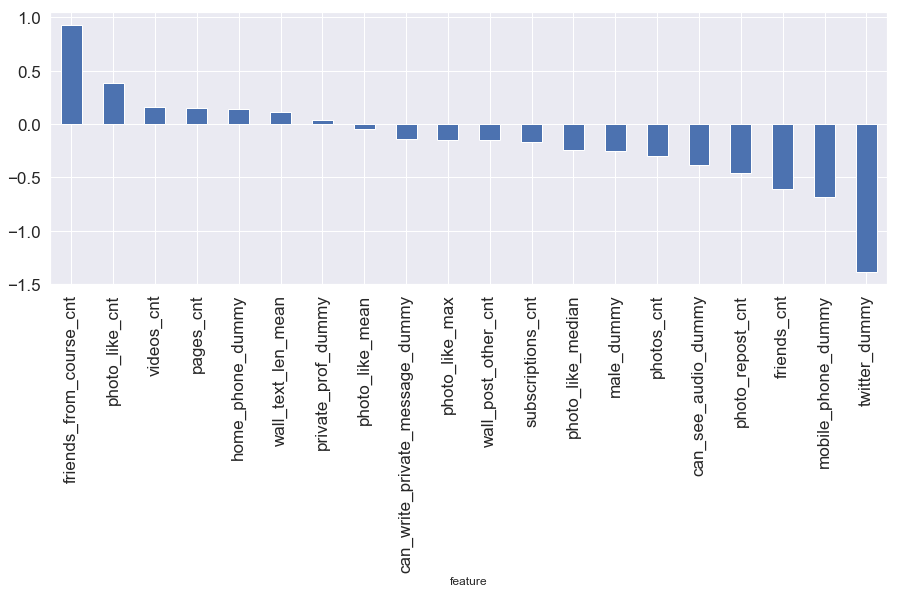

In [44]:
fig, ax = plt.subplots(figsize=(15,5))
featureImportance = pd.DataFrame({"feature": best_variables, 
                                  "importance": model_huber.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', fontsize=17);

Теперь давайте визуализируем прогнозы. По оси $x$ отложены рельные значения лайков, по оси $y$ отложены прогнозы. Если модель работает хорошо, прогноз должен совпадать с реальным значением и наши точки на обоих картинках должны выстроиться вдоль диагонали. Мы видим, что такого не происходит. Наша модель работает довольно плохо. Предсказывать количество лайков по характеристикам со странички в социальной сети у нас пока что не выходит... __Но зато есть домашнее задание! И в нём, возможно, у вас получится это сделать хорошо (или нет).__

In [50]:
def plot_yreal_ypred(y_test, y_train, X_test, X_train, model, margin=0.3):
    """
        Рисует картинку для прогнозов
            modelt - модель 
            y_train, X_train - обучающая выборка
            y_test, X_test - тестовая выборка
            margin - граница рисунка 
    """
    
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    plt.scatter(y_train, model.predict(X_train), color="red", alpha=0.1)
    plt.xlim(min(y_train) - margin, max(y_train) + margin)
    plt.ylim(min(y_train) - margin, max(y_train) + margin)
    plt.title('Train set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)

    plt.subplot(122)
    plt.scatter(y_test, model.predict(X_test), color="red", alpha=0.1)
    plt.xlim(min(y_test) - margin, max(y_test) + margin)
    plt.ylim(min(y_test) - margin, max(y_test) + margin)
    plt.title('Test set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)
    pass

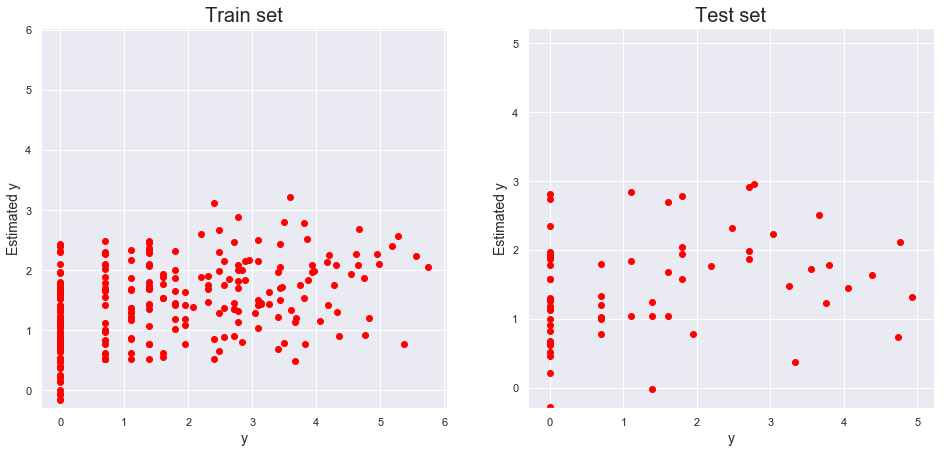

In [49]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, model_huber)

Только что мы получили с вами уникальный опыт: __потерпели неудачу.__ К ним надо быть готовым. Как можно постараться победить и научится прогнозировать лаки ну хоть сколько-нибудь хорошо? Нужно собрать больше данных. 

* Большая часть переменных, которая у нас есть не даёт никакого вклада в прогноз. Наверное, мы пропустили при сборе данных самые важные переменные. Надо попробовать подумать о том кадобавочка каких переменных поможет нам улучшить прогноз и собрать информацию по ним. 
* Более того, может быть у нас мало наблюдений и на них не прослеживается взаимосвязь между переменными. Может быть, если мы соберём в выборку больше людей, ситуация улучшится. 
* А может быть мы плохо сформулировали задачу и нам вовсе не нужно пытаться прогнозировать число лайков под постом, а нужно что-то другое. Ситуации, когда заказчик сам не понимает чего хочет, встречаются сплошь и рядом. 

Давайте посмотрим теперь на ещё две картинки. Если бы мы построили хорошую модель, то на картинке она бы выглядела как-то вот так: 

![](https://raw.githubusercontent.com/FUlyankin/HSE_Data_Culture/master/Intro_to_DS_2019/sem_6_regression/nice_regression.png)

Видите? На тренировчной и на тестовой выборке точки довольно сильно вытянуты вдоль диагонали. Если мы видим такую картину, значит модели удалось вычленить из данные довольно много полезных закономерностей, и прогнозы строятся хорошо.

Вопрос на засыпку: а что, если облако на тренировочной выборке оказывается вытянутым, а на тестовой выборке оказывается толстым? Например, для наших данных можно добиться вот такой картинки: 

![](https://raw.githubusercontent.com/FUlyankin/HSE_Data_Culture/master/Intro_to_DS_2019/sem_6_regression/regr_bad.png)

Что мы видим на ней? На тренировочной выборке наши прогнозы близки к идеальным, а на тестовой выборке они ужасные и даже близко к диагонали не лежат. Что это означает? Это означает, что мы переобучились. Мы хорошо научились ориентироваться в каких-то частных особенностях тренировочной выборки и строить прогнозы для неё. Но то, что мы запомнили эти частные особенности, никак нам не помогает хорошо прогнозировать $y$ для ноовых объектов. То есть модель оказывается бесполезной. 